# Example

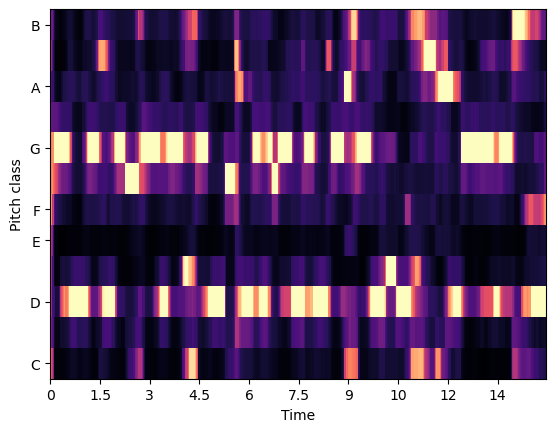

In [1]:
# Chromagram extraction example
import matplotlib.pyplot as plt
import librosa

# Removing noise from chromagram
import numpy as np
import scipy

# Load the example clip (Brahms - Hungarian Dance #5)
y, sr = librosa.load(librosa.ex('brahms'))

# Separate harmonics and percussives into two waveforms
# Working with pure harmonic signal leads to less noise
y_harmonic, y_percussive = librosa.effects.hpss(y)

# Compute chroma features from the harmonic signal
chromagram = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)

# Apply extra filtering
chromagram = np.minimum(chromagram,
                   librosa.decompose.nn_filter(chromagram,
                                               aggregate=np.median,
                                               metric='cosine'))
chromagram = scipy.ndimage.median_filter(chromagram, size=(1, 9))

# Showing first 15 seconds
idx = tuple([slice(None), slice(*list(
    librosa.time_to_frames([0, 15])))])

# Export the chromagram as PNG file
fig = plt.figure()
img = librosa.display.specshow(chromagram[idx],
                    y_axis='chroma', x_axis='time')
plt.savefig('brahms.png', bbox_inches='tight')

# Preparing Input

In [ ]:
# Generating chromagrams
import matplotlib.pyplot as plt
import librosa

# Removing noise from chromagrams
import numpy as np
import scipy

# Create chromagram database
# Retrieve all data file names
from glob import glob
for i in glob("./data_dir/*"):
    for j in glob(''.join([i, "/*.ogg"])):

        # Load the clip
        y, sr = librosa.load(j)

        # Separate harmonic signal from percussive signal
        y_harmonic = librosa.effects.harmonic(y=y, margin=8)

        # Compute chroma feature from the harmonic signal
        chromagram = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)

        # Apply extra filtering
        chromagram = np.minimum(chromagram,
                           librosa.decompose.nn_filter(chromagram,
                                                       aggregate=np.median,
                                                       metric='cosine'))
        chromagram = scipy.ndimage.median_filter(chromagram, size=(1, 9))

        # Export the chromagram as PNG file
        fig = plt.figure()
        img = librosa.display.specshow(chromagram)
        plt.savefig(''.join([j, ".png"]), bbox_inches='tight')

        # Free memory
        plt.close(fig)

# Load Dataset

In [2]:
# Machine learning
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

# Dataset loading settings
batch_size = 32
img_height = 16
img_width = 16

# Loading training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory="data_dir",
  validation_split=0.25,
  subset="training",
  seed=1234,
  image_size=(img_height, img_width),
  batch_size=batch_size)

print()

# Loading validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory="data_dir",
  validation_split=0.25,
  subset="validation",
  seed=1234,
  image_size=(img_height, img_width),
  batch_size=batch_size)

2024-01-13 14:30:15.032269: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 14:30:15.067964: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 14:30:15.898233: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


TensorFlow version: 2.13.1
Found 1157 files belonging to 12 classes.
Using 868 files for training.

Found 1157 files belonging to 12 classes.
Using 289 files for validation.


In [3]:
# Retrieve keys (labels)
#class_names = librosa.midi_to_note(range(12), octave=False, cents=False, key="C:maj", unicode=True)
class_names = train_ds.class_names
print("Class names:", class_names)

Class names: ['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#']


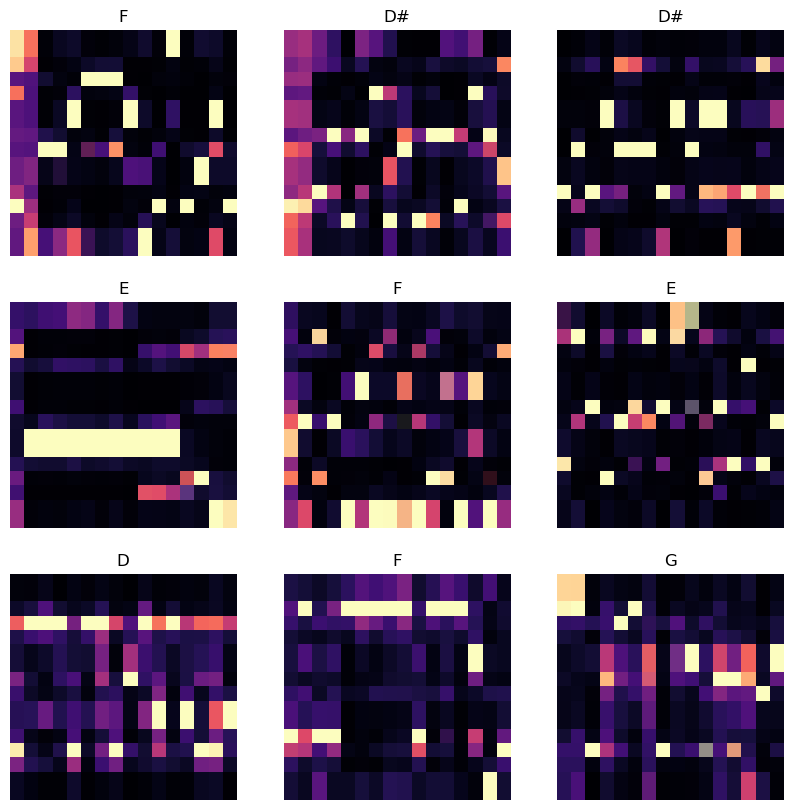

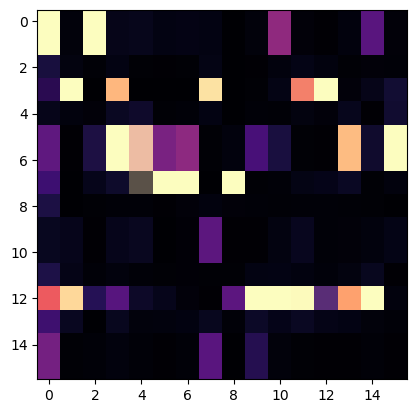

In [4]:
# Visualize the data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    
# Preview one element
plt.figure()
for image, label in train_ds.take(1):
    plt.imshow(image[0].numpy().astype("uint8"))

# Train the Model

In [5]:
# Inspect dimensions of input
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Prepare callbacks
#!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

import pathlib
import shutil
import tempfile

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# Prepare early stopping of training
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 1),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

(32, 16, 16, 3)
(32,)


In [6]:
# Training model
num_classes = len(class_names)

model = tf.keras.Sequential([
  # Preprocessing (color to grayscale)
  tf.keras.layers.Rescaling(1./255),

  # Convolution Layer
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
    
  # Turning 2D array to a vector
  tf.keras.layers.Flatten(),
    
  # Learning Layer
  tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation='relu'),
  tf.keras.layers.Dropout(0.5),
    
  # Output Layer
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

# Early stopping is used, so an arbitrarily big number is put here
max_epochs=100

history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = max_epochs,
  callbacks = get_callbacks('Test'),
  #verbose = 0
)


Epoch 1/100
18/28 [==================>...........] - ETA: 0s - loss: 2.4289 - accuracy: 0.1597
Epoch: 0, accuracy:0.1751,  loss:2.3770,  val_accuracy:0.2941,  val_loss:2.1427,  
28/28 [==============================] - 1s 19ms/step - loss: 2.3770 - accuracy: 0.1751 - val_loss: 2.1427 - val_accuracy: 0.2941
Epoch 2/100
28/28 [==============================] - 0s 5ms/step - loss: 2.1020 - accuracy: 0.2707 - val_loss: 1.9683 - val_accuracy: 0.3841
Epoch 3/100
28/28 [==============================] - 0s 5ms/step - loss: 1.9858 - accuracy: 0.3134 - val_loss: 1.9167 - val_accuracy: 0.3875
Epoch 4/100
28/28 [==============================] - 0s 5ms/step - loss: 1.8588 - accuracy: 0.3606 - val_loss: 1.8262 - val_accuracy: 0.4256
Epoch 5/100
28/28 [==============================] - 0s 5ms/step - loss: 1.8153 - accuracy: 0.3571 - val_loss: 1.7880 - val_accuracy: 0.4533
Epoch 6/100
28/28 [==============================] - 0s 5ms/step - loss: 1.7248 - accuracy: 0.4067 - val_loss: 1.8094 - val_accu

# Analyzing Results

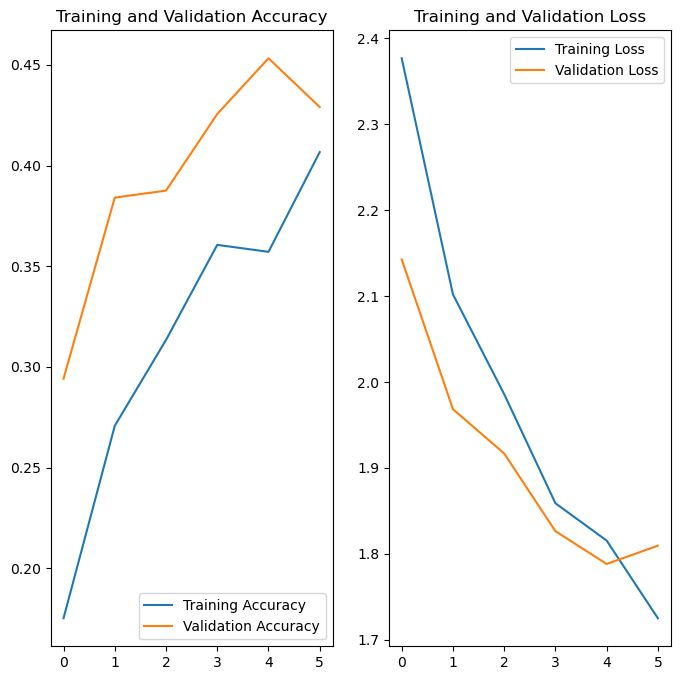

In [7]:
# Accuracy and loss function plots
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.savefig("results.png", bbox_inches='tight')

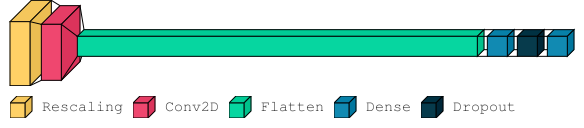

In [8]:
# Visualize the model
import visualkeras
from PIL import ImageFont

# Select model diagram font
font = ImageFont.truetype("/usr/share/fonts/truetype/freefont/FreeMono.ttf", 15)

# Generate image
visualkeras.layered_view(model, legend=True, font=font, to_file='model.png')

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Get true labels
y_test = np.concatenate([y for x, y in val_ds], axis=0)

# Get predictions
probabilities = model.predict(val_ds)
y_pred = np.argmax(probabilities, axis=1)

# Get reports
#print('Classification Report: \n', classification_report(y_test,y_pred))
#print('Confusion Matrix: \n', confusion_matrix(y_test,y_pred))

In [ ]:
# Visualize confusion matrix as heatmap
import seaborn as sn
import pandas as pd

df_cm = pd.DataFrame(cnf_matrix, index = class_names,
                  columns = class_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

plt.savefig("cnf.png", bbox_inches='tight')